In [1]:
%matplotlib inline
import sys
sys.path.append('./bdit_traffic_prophet/')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [2]:
tcs = reader.read(vol_conn)

In [3]:
from traffic_prophet.countmatch import permcount
permcount.get_ptcs_sttcs(tcs)

In [4]:
tcs.ptcs.keys()

dict_keys([-890, 1003, 1821, -104870, -106797, 106898, 438481, -440332, 440429, -442161, 442292, -442447, 442871, -442915, 443071, -443987, 444403, 444516, -444637, 444782, 446012, -1141572, 1144030, -1144036, -1145202, 1145202, 1145376, -1145405, -1145667, 1145768, 1146181, 1146200, -1146202, -1146335, -1146358, 1146445, -1146615, 1146843, -1146997, 1147010, 1147026, 1147078, -1147113, 1147127, -1147184, 1147194, -1147201, 1147201, -1147234, -1147316, -1147347, 1147347, 1147412, -1147434, 1147464, -1147466, 1147466, 1147489, 1147544, 1147551, 2370044, 4341781, 5439677, 5439765, 5849817, 5866210, 5999366, -6388019, -6837741, 6837747, 8396807, -8491741, 8492502, 8540609, -9212691, 9212691, -9313402, -10924071, -11129605, -12334583, -12334941, 12335504, 12335513, -12336156, -12336171, -12387683, -12763897, -13515818, -13975065, -13975074, -14073969, 14073981, 14134895, -14255077, 14255077, 14309611, -20037402, 20043629, 20044187, -20050591, 20054564, -20054568, 30007492, -30010427, -3001

In [5]:
nan_fraction = [np.isnan(tcs.ptcs[key].ratios['DoM_ijd'].values).sum() / (tcs.ptcs[key].ratios['DoM_ijd'].shape[0] * 7)
                for key in tcs.ptcs.keys()]

In [6]:
kyd.kyd(nan_fraction);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.0         -99 CI:   0.0         | Number of Dimensions:   1    	|
|   0.001923        1Q:   0.0         -95 CI:   0.0         | Shape of Dimensions:    (166,)	|
|               Median:   0.0         -68 CI:   0.0         | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.0         +68 CI:   0.001429    | Memory Size:            1.4KiB	|
|   0.006924       Max:   0.05952     +95 CI:   0.01786     |                              	|
|                                     +99 CI:   0.0497      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

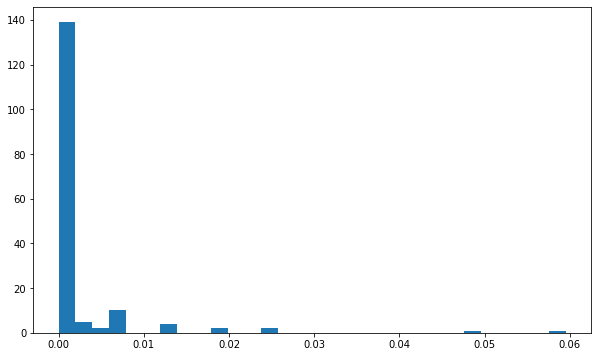

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(nan_fraction, bins=30);

In [8]:
# The fraction of NaNs never exceeds around 5%, and plenty of locations have no NaNs.
# Let's try dropping that number from those locations with no NaNs.

complete_ptcs = [key for key in sorted(list(tcs.ptcs.keys())) if ~np.any(np.isnan(tcs.ptcs[key].ratios['DoM_ijd']))]
doms = [tcs.ptcs[key].ratios['DoM_ijd'].values.copy() for key in complete_ptcs]
dijds = [tcs.ptcs[key].ratios['D_ijd'].values.copy() for key in complete_ptcs]

In [9]:
# Remove 5% of missing values at random from copies of doms and dijds.
# Fit with imputer.

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
imp = impute.IterativeImputer(max_iter=10)

doms_withnan = []
dijds_withnan = []
doms_imputed = []
dijds_imputed = []

for i in range(len(complete_ptcs)):
    c_dom = doms[i].copy().ravel()
    c_dijd = dijds[i].copy().ravel()
    
    nan_indices = np.random.choice(
        np.arange(len(c_dijd), dtype=int),
        np.round(0.05 * len(c_dijd)).astype(int), replace=False)
    
    c_dom[nan_indices] = np.nan
    c_dijd[nan_indices] = np.nan
    
    doms_withnan.append(c_dom.reshape(doms[i].shape))
    dijds_withnan.append(c_dijd.reshape(doms[i].shape))
    
    doms_imputed.append(imp.fit_transform(doms_withnan[-1]))
    dijds_imputed.append(imp.fit_transform(dijds_withnan[-1]))

/home/czhu/pipenv/bditto/lib/python3.6/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [10]:
# Check imputation results.
from sklearn import metrics

def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs(y - y_pred) / y) * 100.

maes_dom = []
mapes_dom = []
cov_dom = []

for i in range(len(complete_ptcs)):
    cdom = doms[i].ravel()
    cdom_nans = np.isnan(doms_withnan[i].ravel())
    cdom_imputed = doms_imputed[i].ravel()
    maes_dom.append(metrics.mean_absolute_error(cdom[cdom_nans], cdom_imputed[cdom_nans]))
    mapes_dom.append(mean_absolute_percentage_error(cdom[cdom_nans], cdom_imputed[cdom_nans]))
    cov_dom.append(np.std(cdom) / np.mean(cdom))
    
maes_dijd = []
mapes_dijd = []
cov_dijd = []

for i in range(len(complete_ptcs)):
    cdijd = dijds[i].ravel()
    cdijd_nans = np.isnan(dijds_withnan[i].ravel())
    cdijd_imputed = dijds_imputed[i].ravel()
    maes_dijd.append(metrics.mean_absolute_error(cdijd[cdijd_nans], cdijd_imputed[cdijd_nans]))
    mapes_dijd.append(mean_absolute_percentage_error(cdijd[cdijd_nans], cdijd_imputed[cdijd_nans]))
    cov_dijd.append(np.std(cdijd) / np.mean(cdijd))

In [11]:
kyd.kyd(maes_dom);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.007214    -99 CI:   0.00944     | Number of Dimensions:   1    	|
|   0.04099         1Q:   0.02428     -95 CI:   0.01391     | Shape of Dimensions:    (139,)	|
|               Median:   0.03729     -68 CI:   0.02132     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.0487      +68 CI:   0.05942     | Memory Size:            1.2KiB	|
|   0.02507        Max:   0.1688      +95 CI:   0.1002      |                              	|
|                                     +99 CI:   0.1647      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [12]:
kyd.kyd(mapes_dom);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.7313      -99 CI:   0.9243      | Number of Dimensions:   1    	|
|    3.979          1Q:   2.409       -95 CI:   1.414       | Shape of Dimensions:    (139,)	|
|               Median:   3.616       -68 CI:   2.091       | Array Data Type:        float64	|
|   Std Dev:        3Q:   4.919       +68 CI:   5.78        | Memory Size:            1.2KiB	|
|    2.311         Max:   17.09       +95 CI:   9.189       |                              	|
|                                     +99 CI:   15.28       | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

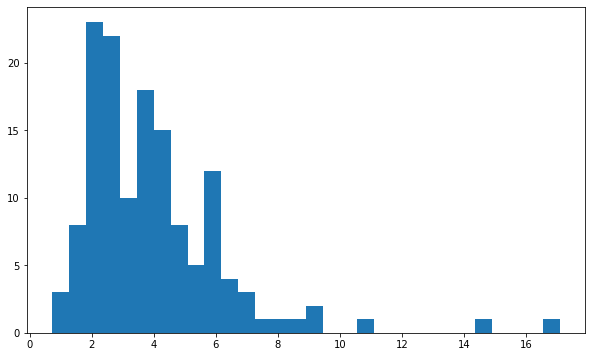

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(mapes_dom, bins=30);

In [14]:
kyd.kyd(cov_dom);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.03611     -99 CI:   0.03941     | Number of Dimensions:   1    	|
|    0.1199         1Q:   0.07371     -95 CI:   0.04512     | Shape of Dimensions:    (139,)	|
|               Median:   0.09584     -68 CI:   0.0666      | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.1407      +68 CI:   0.1727      | Memory Size:            1.2KiB	|
|   0.07679        Max:   0.5606      +95 CI:   0.2868      |                              	|
|                                     +99 CI:   0.5406      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [15]:
kyd.kyd(np.array(maes_dom) / np.array(cov_dom));

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.05097     -99 CI:   0.05151     | Number of Dimensions:   1    	|
|    0.3831         1Q:   0.2535      -95 CI:   0.1292      | Shape of Dimensions:    (139,)	|
|               Median:   0.3447      -68 CI:   0.2125      | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.4729      +68 CI:   0.5389      | Memory Size:            1.2KiB	|
|    0.1936        Max:   1.357       +95 CI:   0.8304      |                              	|
|                                     +99 CI:   1.18        | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [16]:
kyd.kyd(maes_dijd);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.01538     -99 CI:   0.01554     | Number of Dimensions:   1    	|
|   0.04906         1Q:   0.03062     -95 CI:   0.01821     | Shape of Dimensions:    (139,)	|
|               Median:   0.03971     -68 CI:   0.02557     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.05556     +68 CI:   0.06788     | Memory Size:            1.2KiB	|
|   0.03807        Max:   0.3718      +95 CI:   0.1291      |                              	|
|                                     +99 CI:   0.2371      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [17]:
kyd.kyd(mapes_dijd);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   1.61        -99 CI:   1.673       | Number of Dimensions:   1    	|
|    4.716          1Q:   3.08        -95 CI:   1.862       | Shape of Dimensions:    (139,)	|
|               Median:   3.901       -68 CI:   2.602       | Array Data Type:        float64	|
|   Std Dev:        3Q:   5.455       +68 CI:   6.288       | Memory Size:            1.2KiB	|
|    3.563         Max:   35.84       +95 CI:   12.42       |                              	|
|                                     +99 CI:   22.09       | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

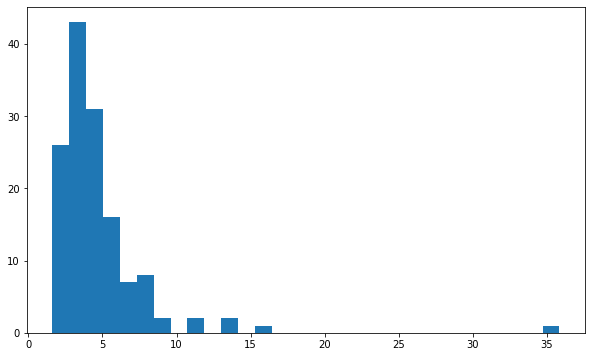

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(mapes_dijd, bins=30);

In [19]:
kyd.kyd(cov_dijd);

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.04416     -99 CI:   0.05996     | Number of Dimensions:   1    	|
|    0.1685         1Q:   0.1005      -95 CI:   0.07043     | Shape of Dimensions:    (139,)	|
|               Median:   0.1338      -68 CI:   0.09198     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.1872      +68 CI:   0.2373      | Memory Size:            1.2KiB	|
|    0.1286        Max:   1.279       +95 CI:   0.4055      |                              	|
|                                     +99 CI:   0.7836      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [20]:
kyd.kyd(np.array(maes_dijd) / np.array(cov_dijd));

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.05633     -99 CI:   0.07858     | Number of Dimensions:   1    	|
|    0.3201         1Q:   0.224       -95 CI:   0.1106      | Shape of Dimensions:    (139,)	|
|               Median:   0.2864      -68 CI:   0.1818      | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.3964      +68 CI:   0.4298      | Memory Size:            1.2KiB	|
|    0.1491        Max:   0.9473      +95 CI:   0.6991      |                              	|
|                                     +99 CI:   0.8671      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

Conclusions:
* Median dataset inputation error is around 4% of the DoM factor's value, and 5% of `D_ijd`.  This is not bad at all (though at the extreme end there is the possibility for 14% error).
* However, imputation is still silly if the typical variation between factors is well below the error (i.e. if all DoM factors are 1.0 +/- 0.0001, and the imputation error is 0.035, we're better off just using a DoM from another year or day of week.).  Happily, the ratio between MAE and COV is typically around 30-40%, meaning there's likely an overall benefit to using the imputation rather than randomly choosing another factor in the matrix to use.
* There are typically far fewer values to impute than 5%, so errors should further improve slightly in practice.
* However, the ultimate test of whether imputation works is if it improves the fit error at the end of CountMatch.  At best, I suspect the error will be unchanged, but this imputation will allow CountMatch to run slightly faster.
* We'll need to rerun this analysis if we start relaxing PTC requirements.

To implement a pointwise substitution:

```python
# https://stackoverflow.com/questions/27159189/find-empty-or-nan-entry-in-pandas-dataframe

imputed_vals = imp.fit_transform(d_ijd)

for i,j in zip(*np.where(d_ijd.isnull())):
    d_ijd.iloc[i, j] = imputed_vals[i, j]
```